### Investigate final_score_unweighted has 16,582 zero values


In [1]:
%run '../lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [5]:
dfFlt = load_df('dfFlt')
types = get_var_types()

#### Create zero value dataframe

In [13]:
zeroDf = dfFlt.filter(F.col('final_score_unweighted') == 0)

#### Count zero values

In [14]:
zeroDf.count()

16582

In [15]:
display_single_val(zeroDf)

,0
assignment_late_submission,False
is_manual_scoring_required,False
learner_attempt_status,fully scored
final_score_unweighted,0
is_deleted,False


- No additional values

###### Categorical / Nominal Correlations Heatmap

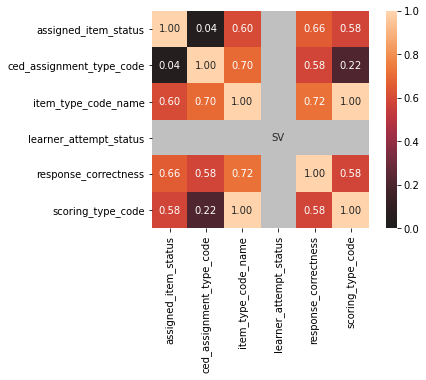

In [16]:
corr, ax = associations( zeroDf.select(*types['nominalVars']).toPandas(), nan_replace_value='null' )

- No new correlations

###### Categorical / Interval Variables

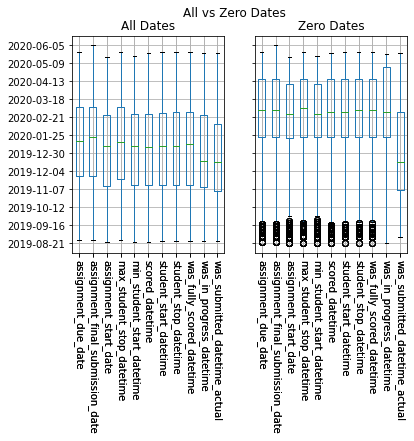

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

date_boxplot(get_random_sample(dfFlt), "All Dates", ax1)

date_boxplot(zeroDf, "Zero Dates", ax2)

plt.suptitle('All vs Zero Dates')

plt.show()

- was_submitted_datetime_actual no obvious change
- Other variables
  - Mean date shifted to 3/2020 vs 1/2020 with Outliers
    - Zeros more often toward end of school year

###### Binary Correlations Heatmap

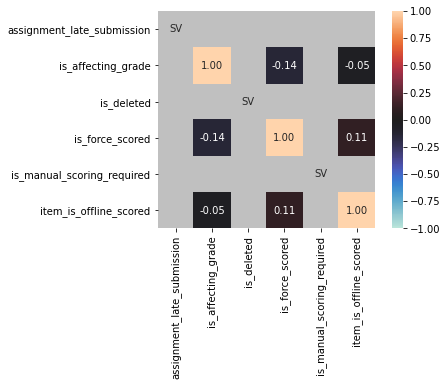

In [18]:
corr, ax = associations( zeroDf.select(*types['binaryVars']).toPandas(), nan_replace_value='null' )

- No correlation
- Unary values in assignment_late_submission, is_manual_scoring_required and is_deleted
  - Remove unary values

###### Check for Correlations of Zero to Categorical Variables

In [3]:
dfZeroCat = dfFlt.withColumn(
                "zero_score",
                  F.when( F.col('final_score_unweighted') == 0, 'Yes').otherwise("No")
                )

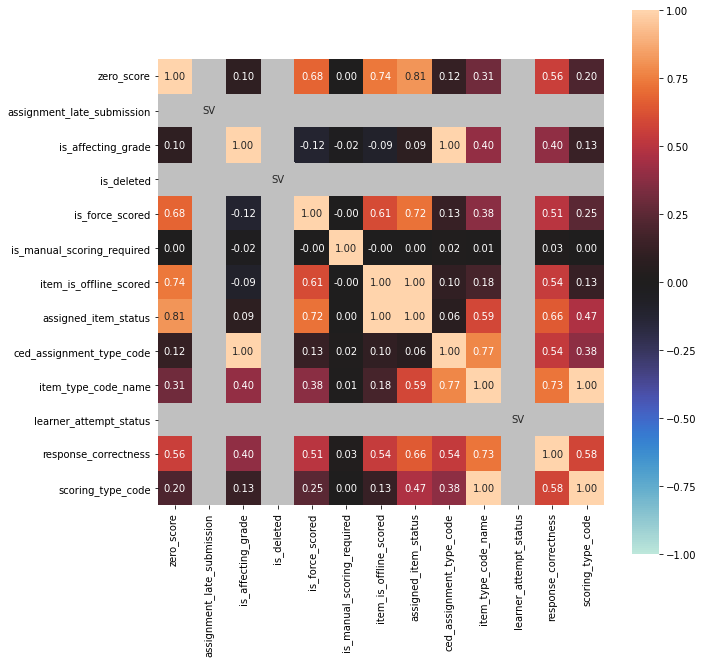

In [9]:
cols = ['zero_score'] + types['binaryVars'] + types['nominalVars']
pdDf = dfZeroCat.select(*cols).toPandas()
corr, ax = associations(pdDf , nan_replace_value='null', figsize=[10,10])

- High correlation between zero_score and assigned_item_status
- Unexpected low correlation between zero_score and response_correctness

###### Display Crosstab of zero_score vs assigned_item_status

In [ ]:
pd.crosstab(pdDf.zero_score, pdDf.assigned_item_status)

- zero_score = No  when assigned_item_status = scored
- zero_score = Yes when assigned_item_status = offline_scored
  - Is this a error?
  - It doesn't make sense offline_scored correlates to a score of zero

###### Display Crosstab of zero_score vs response_correctness

In [11]:
pd.crosstab(pdDf.zero_score, pdDf.response_correctness)

response_correctness,[unassigned],correct,incorrect,null,partially_correct
zero_score,,,,,
No,1556,42796,17434,794,1386
Yes,10,965,13062,2504,41


- 17,434 response_correctness = incorrect when score is not zero
  - You get a score when it's wrong?

In [ ]:

def sections_by_org():
  sByO = dfFlt.groupBy('org_id').agg(F.countDistinct('section_id').alias('sections')).orderBy('org_id')
  pdDf = sByO.toPandas()

  # Add mean
  meanSections = sByO.agg(F.round(F.avg(F.col('sections'))).alias('mean')).collect()[0][0]
  # Append row with mean
  pdDf = pdDf.append({'org_id': 'mean', 'sections': meanSections}, ignore_index=True)

  ax = pdDf.plot.bar('org_id','sections', title='Num Sections by Organization')
  annotate_plot(ax)
  plt.show()

sections_by_org()

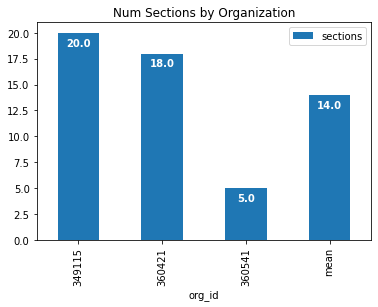

In [20]:
def zero_sections_by_org():
  sByO = zeroDf.groupBy('org_id').agg(F.countDistinct('section_id').alias('sections')).orderBy('org_id')
  pdDf = sByO.toPandas()

  # Add mean
  meanSections = sByO.agg(F.round(F.avg(F.col('sections'))).alias('mean')).collect()[0][0]
  # Append row with mean
  pdDf = pdDf.append({'org_id': 'mean', 'sections': meanSections}, ignore_index=True)

  ax = pdDf.plot.bar('org_id','sections', title='Num Sections by Organization')
  annotate_plot(ax)
  plt.show()

zero_sections_by_org()

- No difference
- TODO